In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor

In [3]:
df = pd.read_csv('Advertising.csv') 
df

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5


### Preprocessing

In [4]:
X = df.drop('Sales', axis=1)
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Selection 

In [5]:
models = {
    'LinearRegression': LinearRegression(),
    'HuberRegression': HuberRegressor(),
    'PassiveAggressiveRegression': PassiveAggressiveRegressor()
}

In [6]:
results = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_cv = np.mean(np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)))
    
    results.append({
        'Model': name, 
        'Run Time': format(round((time.time() - start_time)/60,2)), 
        'RMSE': rmse, 
        'RMSE_CV': rmse_cv})

results_df = pd.DataFrame(results)
print(results_df)

best_model_name = results_df.sort_values(by=['Run Time', 'RMSE', 'RMSE_CV']).iloc[0]['Model']
best_model = models[best_model_name]

                         Model Run Time      RMSE   RMSE_CV
0             LinearRegression      0.0  1.788576  1.737981
1              HuberRegression      0.0  1.888333  1.753490
2  PassiveAggressiveRegression      0.0  2.303879  3.553432


In [7]:

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1, 1, 2],
    'positive': [True, False]
}

grid_search = GridSearchCV(estimator=best_model, 
                           param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error',
                           cv=10)

best_model = grid_search.fit(X_train, y_train) 
print('Optimum parameters', best_model.best_params_)

Optimum parameters {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}


Best Model RMSE: 1.7885761008659662


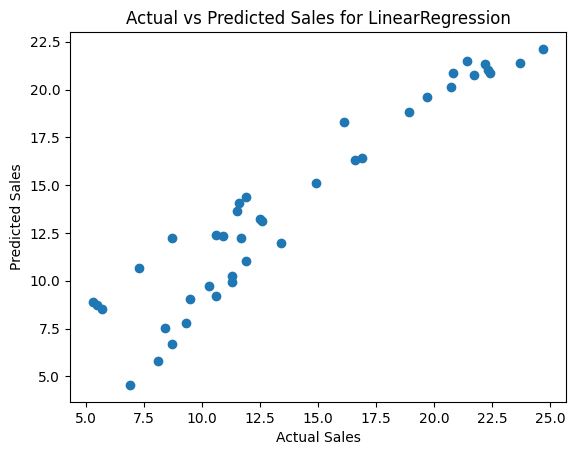

In [8]:
best_model = LinearRegression(copy_X=True, 
                 fit_intercept=True,
                 n_jobs=-1,
                 positive=True)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Model RMSE: {rmse_best}")

# Plot the performance of the best model
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted Sales for {best_model_name}')
plt.show()